# 결측치 제거 

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/Users/chung/Library/Fonts/NanumGothic.otf', 
    name='NanumGothic')                     
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가 (0,fe):가장 우선순위로 추가하겠다는 뜻
plt.rcParams.update({'font.size': 11, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np

# from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)   
pd.set_option('display.max_colwidth', None)  

train_path = '/root/ML_Contest/data/train.csv'
test_path  = '/root/ML_Contest/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

dt['data_type'] = 'train'
dt_test['data_type'] = 'test'

concat = pd.concat([dt, dt_test])    


concat_clean = concat.copy()

concat_clean['등기신청일자'] = concat_clean['등기신청일자'].replace(' ', np.nan)
concat_clean['거래유형'] = concat_clean['거래유형'].replace('-', np.nan)
concat_clean['중개사소재지'] = concat_clean['중개사소재지'].replace('-', np.nan)

print("\n" + "="*80 + "\n") 

# 결측치 기준으로 컬럼 나누기 (복사본 사용)
low_null_cols = list(concat_clean.columns[concat_clean.isnull().sum() <= 1000000])
high_null_cols = list(concat_clean.columns[concat_clean.isnull().sum() > 1000000])

print("\033[31m* 결측치가 100만개 이하인 변수들 :\033[0m", low_null_cols)
print("\n\n")
print("\033[31m* 결측치가 100만개 이상인 변수들 :\033[0m", high_null_cols)

print("\n" + "="*80 + "\n") 

# 결측치 적은 컬럼들만 다시 복사 (여기서 진짜 concat_select 생성)
concat_select = concat_clean[low_null_cols].copy()

concat_select['본번'] = concat_select['본번'].apply(str)
concat_select['부번'] = concat_select['부번'].apply(str)

# 연속형 / 범주형 자동 분리
continuous_columns = concat_select.select_dtypes(include=['number']).columns.tolist()
categorical_columns = concat_select.select_dtypes(exclude=['number']).columns.tolist()

concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 우선 제거 대상 변수
remove_cols = ['k-관리비부과면적', 'k-전체세대수', 'k-연면적']

# 제거 적용
reduced_data = concat_select.drop(columns=remove_cols)

# 보간 대상 변수 목록
interpolate_cols = ['k-전체동수', 'k-주거전용면적', '주차대수','건축면적']

# 선형 보간 적용 (각 컬럼별로 독립적으로)
for col in interpolate_cols:
    reduced_data[col] = reduced_data[col].interpolate(method='linear', limit_direction='both')

# 결측 → 0으로 처리할 변수 리스트
zero_fill_cols = [
    'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)',
    'k-85㎡~135㎡이하'
]

# 결측치 → 0으로 채우기 (inplace 적용)
reduced_data[zero_fill_cols] = reduced_data[zero_fill_cols].fillna(0)

# 적용 결과 확인 (선택)
print(reduced_data[zero_fill_cols].isnull().sum())




* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'data_type']



* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
dtype: int64


In [3]:
# 1. 데이터 불러오기
seoul_apt = pd.read_csv('서울시 공동주택 아파트 정보.csv', encoding='cp949')

# 2. 도로명 + 상세주소 합치기 → '도로명 주소' 컬럼 생성
seoul_apt['도로명'] = seoul_apt['주소(도로명)'].astype(str).str.strip() + ' ' + seoul_apt['주소(도로상세주소)'].astype(str).str.strip()

# 3. 필요한 컬럼만 추출
seoul_apt = seoul_apt[['도로명', '좌표X', '좌표Y']]

# 4. 데이터 타입 변경
seoul_apt['좌표X'] = pd.to_numeric(seoul_apt['좌표X'], errors='coerce')

# 5. Merge (좌표 매핑)
merged_data = pd.merge(
    reduced_data,
    seoul_apt,
    on='도로명',
    how='left',
    suffixes=('', '_외부')
)

# 6. 좌표 결측치 채우기 (외부 좌표로)
merged_data['좌표X'] = merged_data['좌표X'].fillna(merged_data['좌표X_외부'])
merged_data['좌표Y'] = merged_data['좌표Y'].fillna(merged_data['좌표Y_외부'])

# 7. 불필요한 컬럼 삭제
merged_data = merged_data.drop(columns=['좌표X_외부', '좌표Y_외부', '도로명'])

# 8. 좌표X, 좌표Y 선형 보간 (양방향 보간)
merged_data['좌표X'] = merged_data['좌표X'].interpolate(method='linear', limit_direction='both')
merged_data['좌표Y'] = merged_data['좌표Y'].interpolate(method='linear', limit_direction='both')



In [4]:
# 1. 전체 결측치 개수 확인 (컬럼별)
missing_summary = merged_data.isnull().sum()

# 2. 결측치가 존재하는 컬럼만 필터링
missing_columns = missing_summary[missing_summary > 0]

# 3. 결과 출력
print("📌 전체 결측치 현황 (결측치가 있는 컬럼만):\n")
for col, missing_count in missing_columns.items():
    print(f" - {col}: {missing_count:,}개")

# 4. 결측치 있는 컬럼명만 리스트로 추출 (필요시)
missing_cols_list = missing_columns.index.tolist()

📌 전체 결측치 현황 (결측치가 있는 컬럼만):

 - target: 9,915개


# 이상치 제거

In [5]:
# 연속형 변수 추출
numeric_cols = merged_data.select_dtypes(include=['number']).columns.tolist()

# 1. train 데이터만 필터링
train_data = merged_data[merged_data['data_type'] == 'train']

# 2. 이상치 분석 (train 데이터 기준)
outlier_summary = {}

for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    outlier_ratio = outlier_count / train_data.shape[0] * 100

    outlier_summary[col] = {'이상치 개수': outlier_count, '비율(%)': round(outlier_ratio, 2)}

# 3. 결과 정리
outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='비율(%)', ascending=False)

display(outlier_df)



,이상치 개수,비율(%)
k-전용면적별세대현황(60㎡~85㎡이하),217947.0,18.25
k-전용면적별세대현황(60㎡이하),208115.0,17.42
k-85㎡~135㎡이하,157622.0,13.20
건축면적,119463.0,10.00
주차대수,118578.0,9.93
k-주거전용면적,110937.0,9.29
k-전체동수,108276.0,9.07
전용면적(㎡),90595.0,7.58
target,80775.0,6.76
층,11301.0,0.95


In [6]:
target_cols = ['건축면적', '주차대수', 'k-주거전용면적', 'k-전체동수', '전용면적(㎡)']

# 이상치 제거 함수 (train 데이터만)
def remove_outliers_iqr(df, cols):
    # 1. train 데이터만 필터링
    train_df = df[df['data_type'] == 'train'].copy()
    test_df = df[df['data_type'] != 'train'].copy()   # test 데이터는 그대로
    
    # 2. 각 변수에 대해 이상치 제거
    for col in cols:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]
    
    # 3. train과 test 다시 합치기
    cleaned_df = pd.concat([train_df, test_df]).sort_index()
    
    return cleaned_df

# 적용
merged_data_clean = remove_outliers_iqr(merged_data, target_cols)

In [7]:
print("Before:", merged_data.shape)
print("After:", merged_data_clean.shape)

print("\n" + "="*80 + "\n") 

print(merged_data['data_type'].value_counts())
print(merged_data_clean['data_type'].value_counts())

Before: (1204322, 41)
After: (843447, 41)


data_type
train    1194407
test        9915
Name: count, dtype: int64
data_type
train    833532
test       9915
Name: count, dtype: int64


# Feature 수정

In [8]:
clean_data = merged_data_clean.copy()

In [9]:
# 제거할 컬럼 리스트
cols_to_drop = [
    '단지신청일', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호',
    'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
    'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
    '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
    'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
    '청소비관리형태', '경비비관리형태', '세대전기계약방법', 'k-수정일자','고용보험관리번호'
]

# DataFrame에서 컬럼 제거 (예: clean_data 기준)
clean_data = clean_data.drop(columns=cols_to_drop)

In [10]:
print("남은 컬럼 수:", clean_data.shape[1])
print("남은 컬럼 목록:\n", clean_data.columns.tolist())

남은 컬럼 수: 18
남은 컬럼 목록:
 ['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data_type']


### 800m내 지하철 개수

In [11]:
# 지하철 데이터
subway_df = pd.read_csv('/root/ML_Contest/data/subway_feature.csv')
subway_coords = np.radians(subway_df[['위도', '경도']].values)

# 2. 거리 계산 함수 (벡터화된 haversine)
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371000  # 지구 반지름 (m)
    dlat = lat2 - lat1[:, np.newaxis]      # Broadcasting
    dlon = lon2 - lon1[:, np.newaxis]
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1[:, np.newaxis]) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# 3. 아파트 좌표 (clean_data 기준)
apt_coords = np.radians(clean_data[['좌표Y', '좌표X']].values)
apt_lat, apt_lon = apt_coords[:, 0], apt_coords[:, 1]
sub_lat, sub_lon = subway_coords[:, 0], subway_coords[:, 1]

# 4. 거리 계산 (아파트 ↔ 지하철역)
distances = haversine_vectorized(apt_lat, apt_lon, sub_lat, sub_lon)

# 5. 800m 반경 내 지하철역 개수 계산
within_800m = (distances <= 800).sum(axis=1)

# 6. 결과 컬럼 추가
clean_data['800m_지하철역_개수'] = within_800m


### COVID 전/후 분리 (계약년월 202001기준)

In [12]:
# 계약년월 기준: 2020년 1월부터 코로나 이후로 간주
clean_data['covid_period'] = (clean_data['계약년월'] >= 202001).astype(int)


#0: 코로나 이전, 1: 코로나 이후

### Baseline 피쳐 추가 

In [13]:
# 1. 시군구 분할 (예: '서울특별시 강남구 도곡동')
clean_data['구'] = clean_data['시군구'].map(lambda x: x.split()[1])
clean_data['동'] = clean_data['시군구'].map(lambda x: x.split()[2])
del clean_data['시군구']

# 2. 계약년월 분할 (예: 202305 → 2023, 05)
clean_data['계약년'] = clean_data['계약년월'].astype('str').map(lambda x: x[:4])
clean_data['계약월'] = clean_data['계약년월'].astype('str').map(lambda x: x[4:])
del clean_data['계약년월']

# 3. 강남/강북 분류
all_gu = list(clean_data['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all_gu if x not in gangnam]

assert len(all_gu) == len(gangnam) + len(gangbuk)

clean_data['강남여부'] = clean_data['구'].apply(lambda x: 1 if x in gangnam else 0)

# 4. 신축여부 (2009년 이후: 신축)
clean_data['신축여부'] = clean_data['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)



### target_log

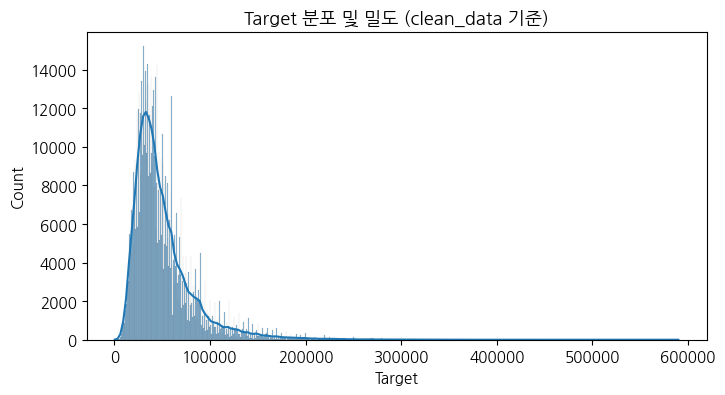

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(clean_data['target'], kde=True)
plt.title("Target 분포 및 밀도 (clean_data 기준)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [15]:
# 로그 변환 전: 0 이하 값 있으면 +1
clean_data['target_for_log'] = clean_data['target'].apply(lambda x: x if x > 0 else 1)

# 로그 변환 적용
clean_data['log_target'] = np.log1p(clean_data['target_for_log'])


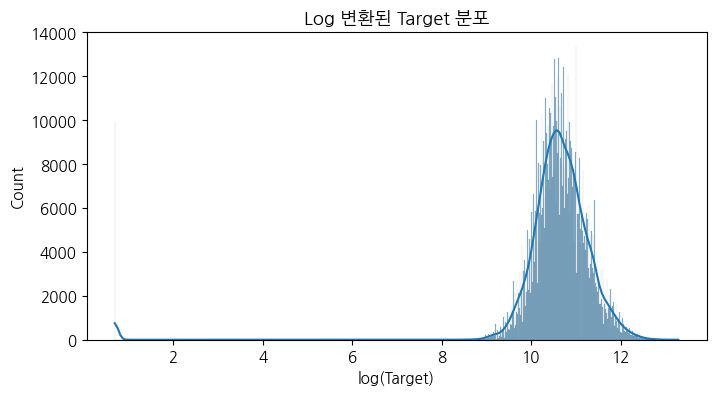

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(clean_data['log_target'], kde=True)
plt.title("Log 변환된 Target 분포")
plt.xlabel("log(Target)")
plt.ylabel("Count")
plt.show()


# Model Training
- 2025.07.14



In [17]:
# 이제 다시 train과 test dataset을 분할해줍니다. 
dt_train = clean_data.query("data_type == 'train'")
dt_test = clean_data.query("data_type == 'test'")

# 이제 data_type 칼럼은 drop.
dt_train.drop(['data_type'], axis = 1, inplace=True)
dt_test.drop(['data_type'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(833532, 25) (9915, 25)


In [18]:
print('data_type' in dt_train.columns)  # False여야 정상
print('data_type' in dt_test.columns) 

False
False


In [19]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적(㎡),계약일,층,건축년도,k-전체동수,k-주거전용면적,건축면적,주차대수,좌표X,좌표Y,target,800m_지하철역_개수,covid_period,구,동,계약년,계약월,강남여부,신축여부,target_for_log,log_target
1194407,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,8.0,20204.0,4858.0,262.0,127.05721,37.476763,NaN,0,1,강남구,개포동,2023,07,1,0,1.0,0.693147


In [20]:
# dt_test의 target은 일단 0으로 임의로 채워주기
dt_test['target'] = 0.0  # 즉, log(1) = 0 으로


### 범주형 변수 Encoding

In [21]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '계약일', '층', '건축년도', 'k-전체동수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '800m_지하철역_개수', 'covid_period', '강남여부', '신축여부', 'target_for_log', 'log_target']
범주형 변수: ['번지', '본번', '부번', '아파트명', '구', '동', '계약년', '계약월']


In [22]:
from tqdm import tqdm

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance

In [23]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


In [24]:
dt_train.head(1) 

,번지,본번,부번,아파트명,전용면적(㎡),계약일,층,건축년도,k-전체동수,k-주거전용면적,건축면적,주차대수,좌표X,좌표Y,target,800m_지하철역_개수,covid_period,구,동,계약년,계약월,강남여부,신축여부,target_for_log,log_target
0,4208,1095,1,275,79.97,8,3,1987,8.0,20204.0,4858.0,262.0,127.05721,37.476763,124000.0,0,0,0,8,10,11,1,0,124000.0,11.728045


### Model training


In [25]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

In [26]:
assert dt_train.shape[1] == dt_test.shape[1]          

# train/test dataset의 shape이 같은지 확인.
#True인 경우 넘어감. False인 경우 (조건을 만족하지 않는 경우) 에러를 발생시켜 프로그램 중단

🔍 Model 성능 비교 (로그 복원 후, 낮을수록 좋음):
              Model          RMSE
2      RandomForest   4861.822927
3           XGBoost   9297.985879
0  LinearRegression  21020.781597
1             Ridge  21021.117308


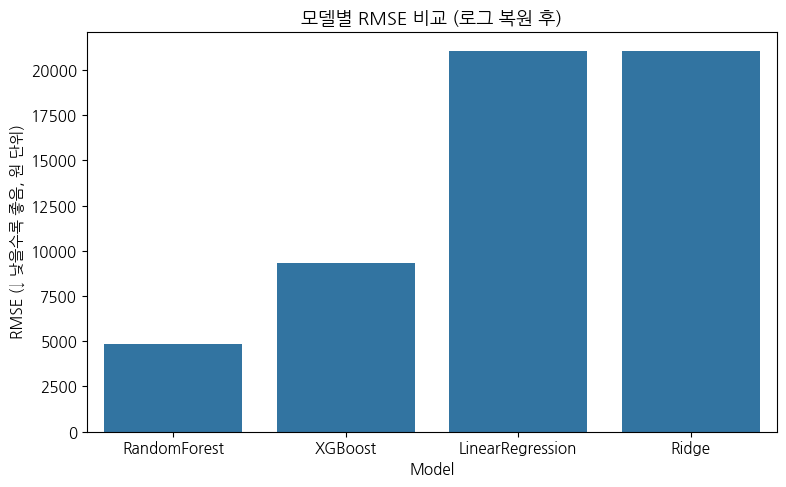

In [27]:
# Target과 독립변수 분리 (log 변환된 타겟 사용)
y = dt_train['log_target']
X = dt_train.drop(['target', 'target_for_log', 'log_target'], axis=1)

# Hold-out split: 학습/검증 데이터 8:2 분리
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2023
)

# 사용할 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1, n_jobs=-1),
    # 'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=1, n_jobs=-1)
}

# 결과 저장 리스트
results = []

# 모델 학습 및 RMSE 계산 (로그 복원 후 원 단위로)
for name, model in models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_val)
    
    # 역변환 (로그 -> 원 단위)
    pred_original = np.expm1(pred_log)
    y_val_original = np.expm1(y_val)
    
    rmse = np.sqrt(mean_squared_error(y_val_original, pred_original))
    results.append({'Model': name, 'RMSE': rmse})

# 결과 정리 및 출력
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)
print("🔍 Model 성능 비교 (로그 복원 후, 낮을수록 좋음):")
print(results_df)

# 시각화
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title("모델별 RMSE 비교 (로그 복원 후)")
plt.ylabel("RMSE (↓ 낮을수록 좋음, 원 단위)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

In [28]:
# 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용.

# Permutation importance 방법을 변수 선택에 이용해보겠습니다.

# sklearn.inspection.permutation_importance 사용
result = permutation_importance(
    model,                      # 학습된 모델
    X_val, y_val,               # 검증용 데이터
    scoring="neg_mean_squared_error",  # 회귀 문제이므로 MSE 사용
    n_repeats=3,                # 3회 반복 (조금 더 안정적인 결과를 위해)
    random_state=42
)

# 중요도 평균값 추출
importance_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
}).sort_values(by='importance', ascending=False)

# 상위 10개 출력
print("🔍 Permutation Importance (Top 10)")
print(importance_df.head(10))

🔍 Permutation Importance (Top 10)
         feature  importance       std
4        전용면적(㎡)    0.150400  0.000455
18           계약년    0.135754  0.000139
13           좌표Y    0.070849  0.000103
12           좌표X    0.037411  0.000062
7           건축년도    0.027231  0.000060
16             구    0.014943  0.000050
2             부번    0.009244  0.000003
15  covid_period    0.004593  0.000059
6              층    0.004291  0.000025
20          강남여부    0.004157  0.000064


### 🚩 오차 큰 샘플만 permutation importance 구하기

In [29]:
# 1. 성능이 가장 좋은 모델로 예측값 구하기
best_model = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1)
best_model.fit(X_train, y_train)
pred_log = best_model.predict(X_val)

# 역변환
y_val_original = np.expm1(y_val)
pred_original = np.expm1(pred_log)

# 2. 잔차 계산
residual = np.abs(y_val_original - pred_original)

# 3. 상위 10% (혹은 원하는 퍼센트)만 인덱스 추출
threshold = np.percentile(residual, 90)
high_error_idx = np.where(residual >= threshold)[0]

# 오차 큰 샘플만 추출
X_high_error = X_val.iloc[high_error_idx]
y_high_error = y_val.iloc[high_error_idx]


In [30]:
from sklearn.inspection import permutation_importance

result_high_error = permutation_importance(
    best_model, X_high_error, y_high_error,
    scoring="neg_mean_squared_error",
    n_repeats=3,
    random_state=42
)

importance_high_error_df = pd.DataFrame({
    'feature': X_high_error.columns,
    'importance': result_high_error.importances_mean,
    'std': result_high_error.importances_std
}).sort_values(by='importance', ascending=False)

print("🔍 Permutation Importance (오차 큰 샘플 Top 10)")
print(importance_high_error_df.head(10))

🔍 Permutation Importance (오차 큰 샘플 Top 10)
    feature  importance       std
18      계약년    0.223635  0.003456
13      좌표Y    0.155815  0.002013
4   전용면적(㎡)    0.139484  0.000468
12      좌표X    0.124917  0.000979
7      건축년도    0.059931  0.000290
16        구    0.053724  0.000246
2        부번    0.026113  0.000175
20     강남여부    0.014788  0.000176
3      아파트명    0.014766  0.000176
17        동    0.009426  0.000346


In [31]:
# 전체 importance_df, 오차 큰 샘플 importance_high_error_df
compare = pd.merge(
    importance_df[['feature', 'importance']].rename(columns={'importance':'전체'}),
    importance_high_error_df[['feature', 'importance']].rename(columns={'importance':'오차큰샘플'}),
    on='feature'
)
compare['rank_diff'] = compare['오차큰샘플'].rank(ascending=False) - compare['전체'].rank(ascending=False)
compare = compare.sort_values('오차큰샘플', ascending=False)
print(compare.head(15))

    feature        전체     오차큰샘플  rank_diff
1       계약년  0.135754  0.223635       -1.0
2       좌표Y  0.070849  0.155815       -1.0
0   전용면적(㎡)  0.150400  0.139484        2.0
3       좌표X  0.037411  0.124917        0.0
4      건축년도  0.027231  0.059931        0.0
5         구  0.014943  0.053724        0.0
6        부번  0.009244  0.026113        0.0
9      강남여부  0.004157  0.014788       -2.0
11     아파트명  0.002695  0.014766       -3.0
10        동  0.003389  0.009426       -1.0
15       본번  0.001535  0.003930       -5.0
8         층  0.004291  0.003693        3.0
13       번지  0.002025  0.003595       -1.0
12      계약월  0.002569  0.002778        1.0
19     건축면적  0.000047  0.002411       -5.0


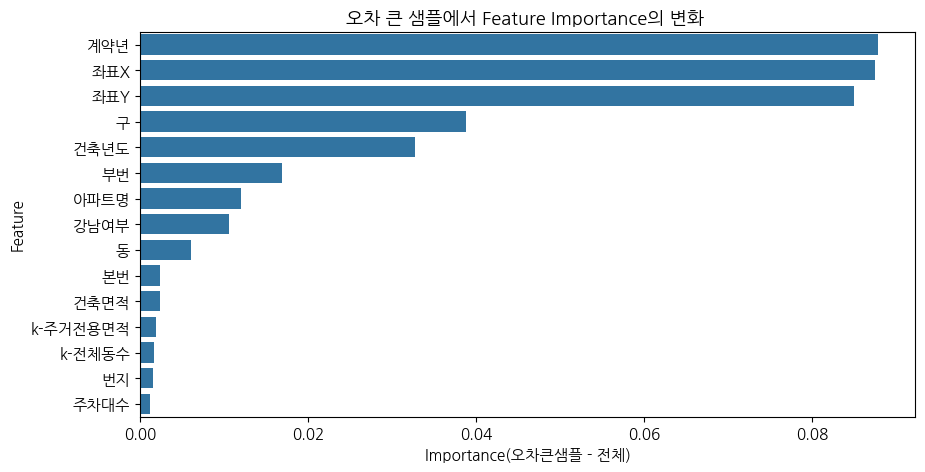

In [33]:
compare['diff'] = compare['오차큰샘플'] - compare['전체']
compare = compare.sort_values('diff', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='diff', y='feature', data=compare.head(15))
plt.title('오차 큰 샘플에서 Feature Importance의 변화 ')
plt.xlabel('Importance(오차큰샘플 - 전체)')
plt.ylabel('Feature')
plt.show()


모델에서 전용면적이 전체적으로는 중요하지만, 오차 큰 샘플에서는 전용면적보다는 계약년, 위치(좌표X, 좌표Y, 구, 강남여부), 건축년도, 세부 주소, 아파트명 등 입지·시점·특수성에 의한 오차가 더 크다

일반적인(보통의, 저/중가) 아파트는 평형(전용면적)만으로 가격 예측이 잘 되지만,


고가/특이 거래/신축/특정 지역 아파트(오차 큰 샘플)는 평형만으로 설명이 안 되고,세부 입지, 시점(계약년), 단지특성, 건축년도 등을 더 고려해야 한다는 뜻. 

In [35]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("수치형 변수 리스트:", numeric_cols)

수치형 변수 리스트: ['번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약일', '층', '건축년도', 'k-전체동수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', '800m_지하철역_개수', 'covid_period', '구', '동', '계약년', '계약월', '강남여부', '신축여부']


In [38]:
import numpy as np
import pandas as pd

# 예측 (ex. RandomForest 등 best_model 기준)
y_val_pred = best_model.predict(X_val)

# log 변환을 썼으면 역변환
y_val_original = np.expm1(y_val)       # 실제값
y_val_pred_original = np.expm1(y_val_pred)  # 예측값

# 오차(잔차, 절댓값)
residual = np.abs(y_val_original - y_val_pred_original)

# DataFrame 생성 (X_val 인덱스와 맞추기)
df_val = X_val.copy()
df_val['y_true'] = y_val_original
df_val['y_pred'] = y_val_pred_original
df_val['residual'] = residual

In [39]:
# 오차 기준 내림차순 정렬 (잔차 큰 순)
df_val_sorted = df_val.sort_values(by='residual', ascending=False)

# 오차 Top 100 (Worst 100)
error_top100 = df_val_sorted.head(100)

# 오차 Bottom 100 (Best 100)
best_top100 = df_val_sorted.tail(100)

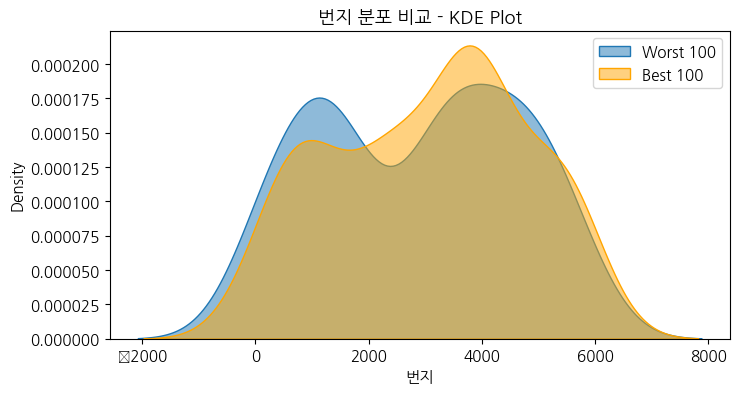

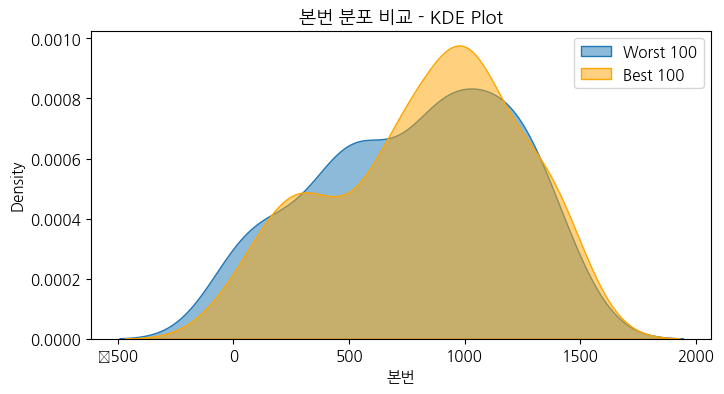

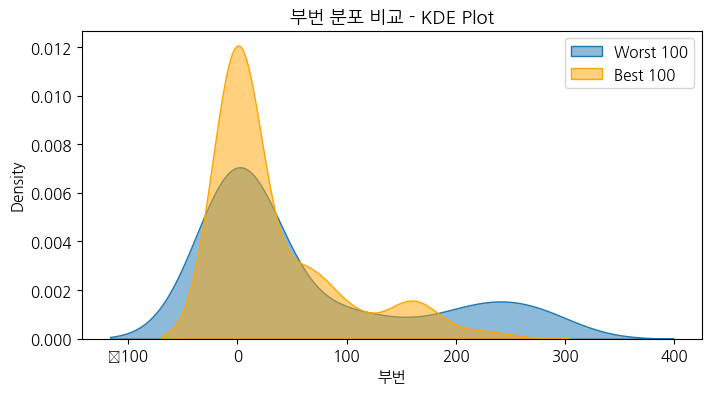

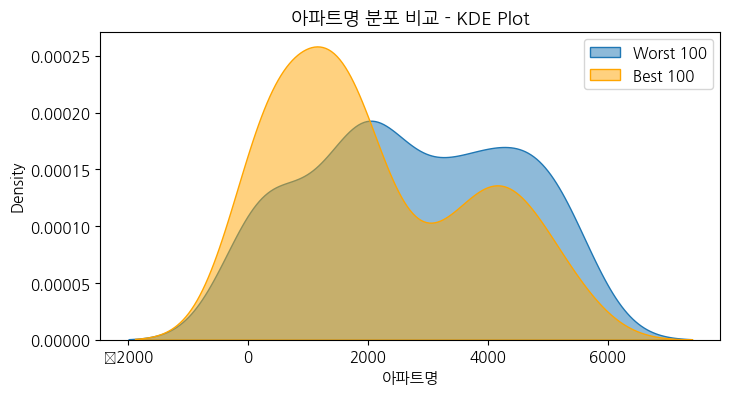

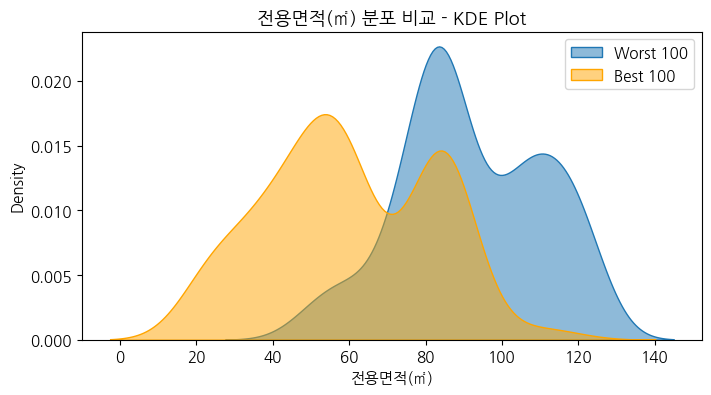

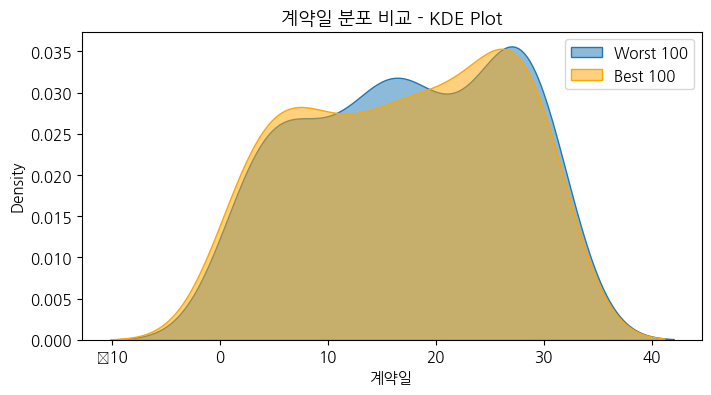

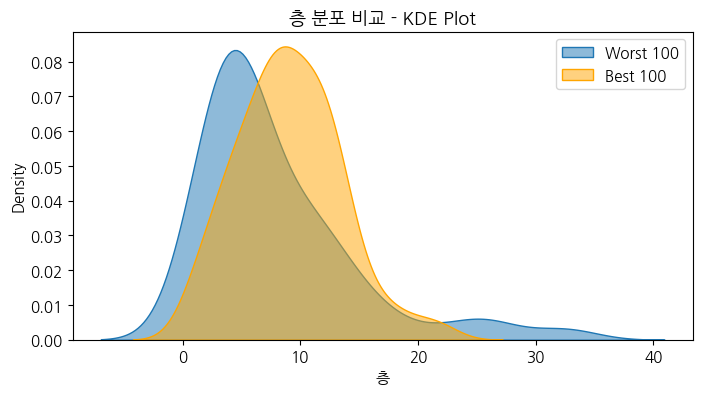

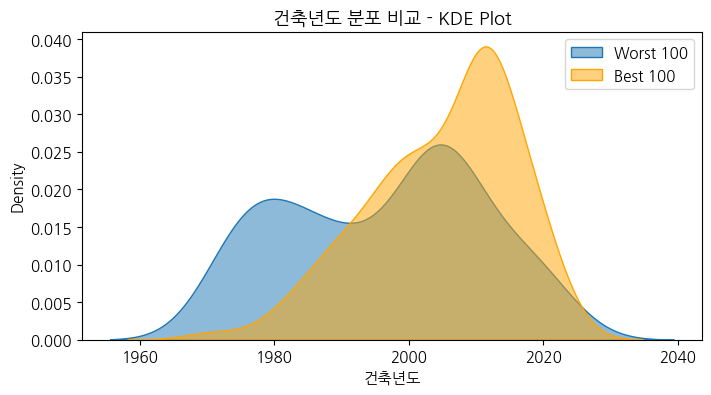

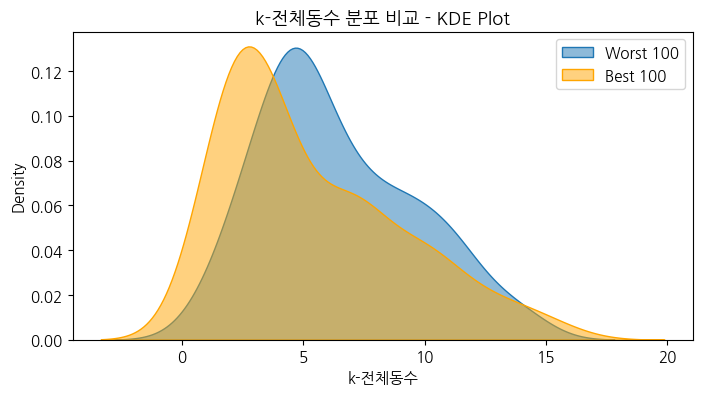

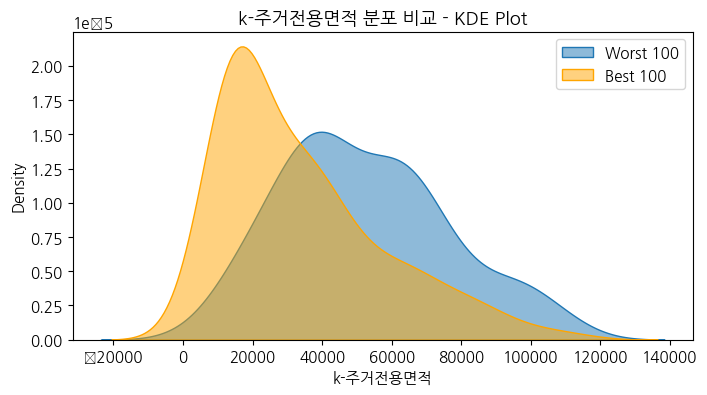

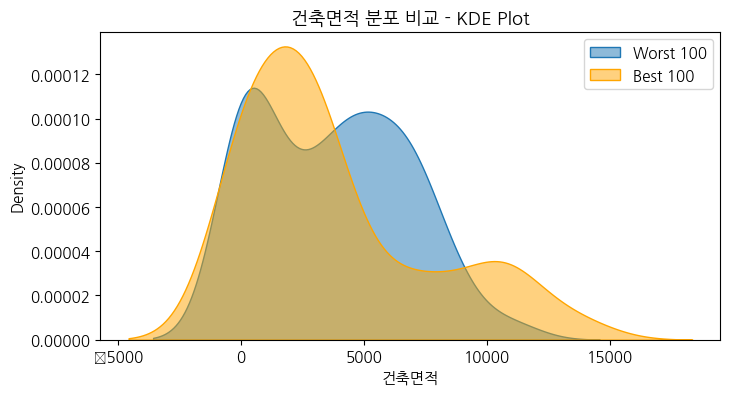

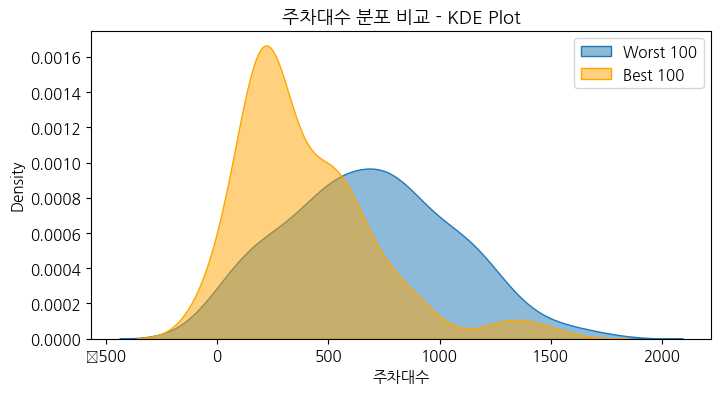

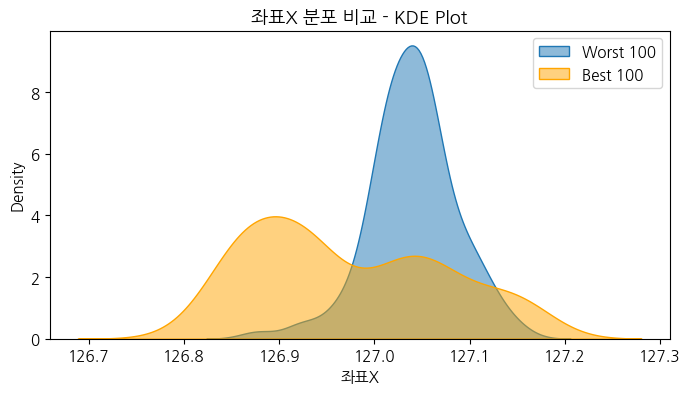

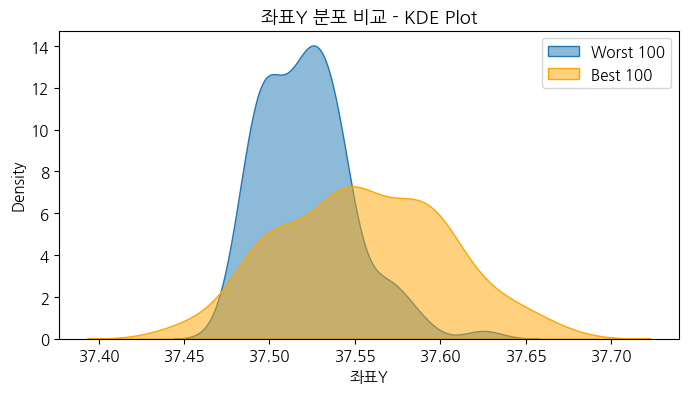

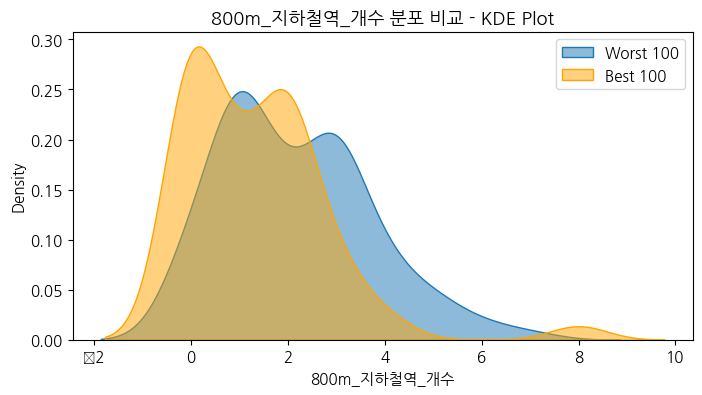

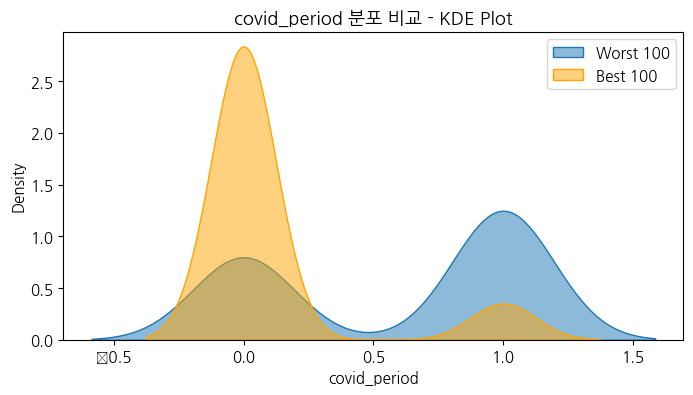

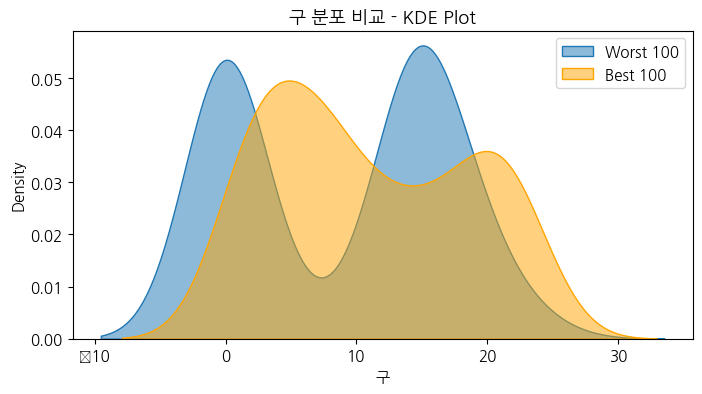

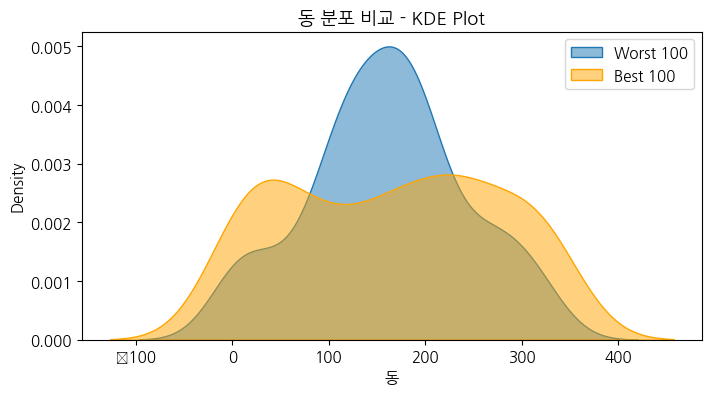

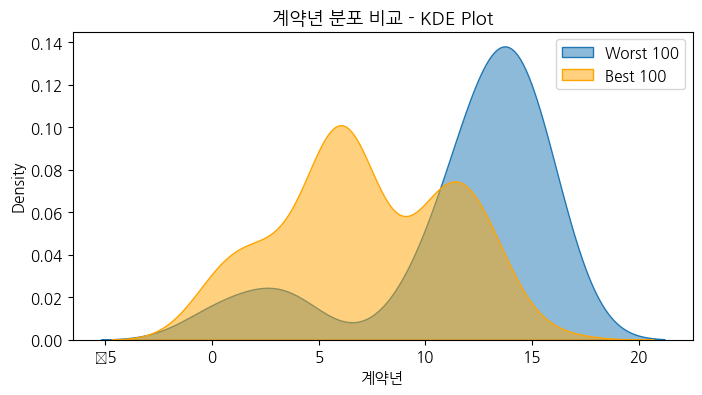

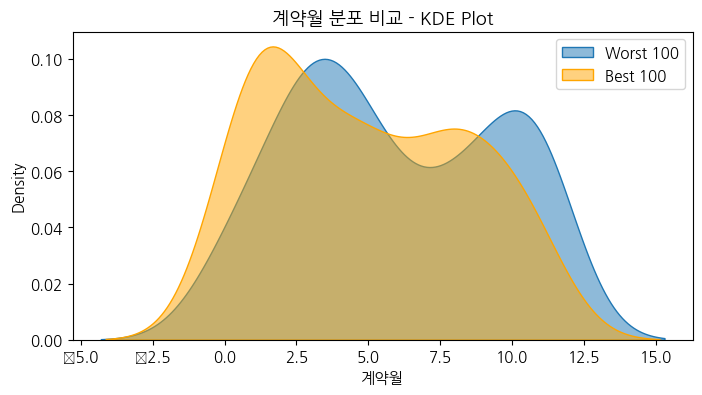

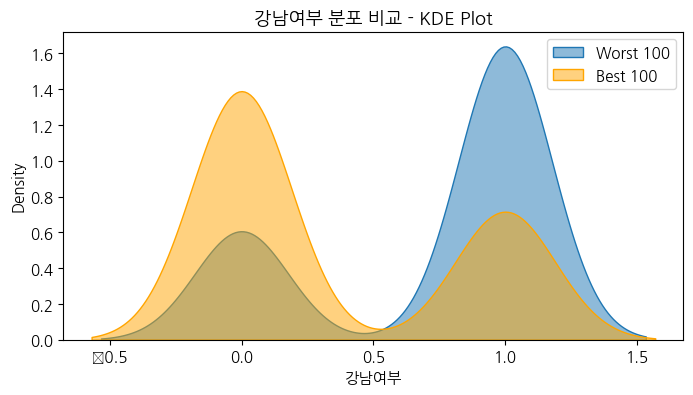

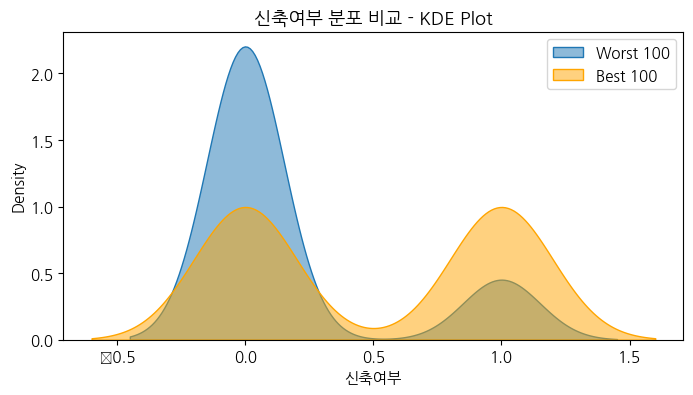

In [40]:
num_cols = ['번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약일', '층', '건축년도',
            'k-전체동수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y',
            '800m_지하철역_개수', 'covid_period', '구', '동', '계약년', '계약월',
            '강남여부', '신축여부']

for col in num_cols:
    plt.figure(figsize=(8,4))
    try:
        sns.kdeplot(data=error_top100, x=col, fill=True, alpha=0.5, label='Worst 100')
        sns.kdeplot(data=best_top100, x=col, fill=True, alpha=0.5, color='orange', label='Best 100')
        plt.title(f"{col} 분포 비교 - KDE Plot")
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"{col} 시각화 중 오류 발생: {e}")


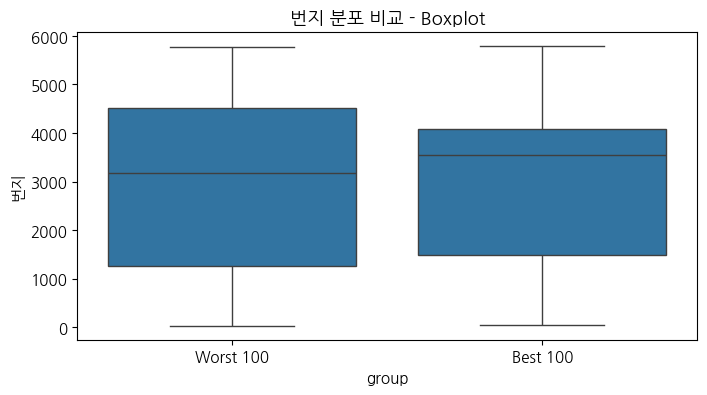

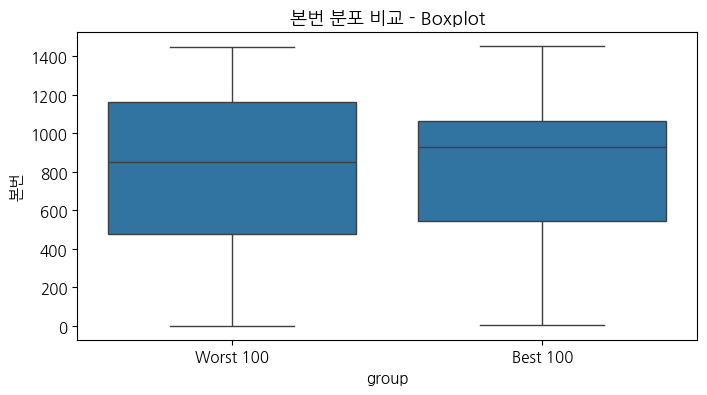

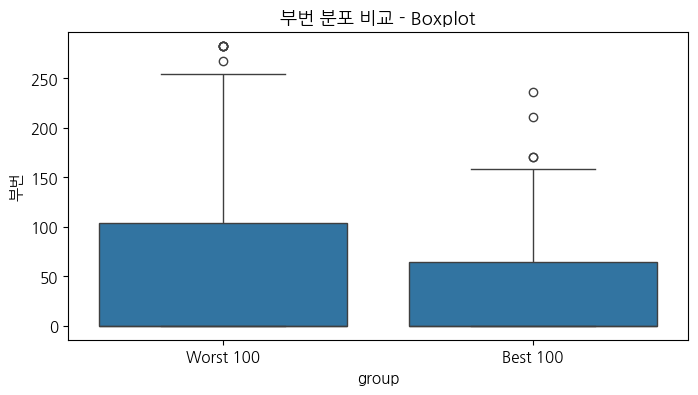

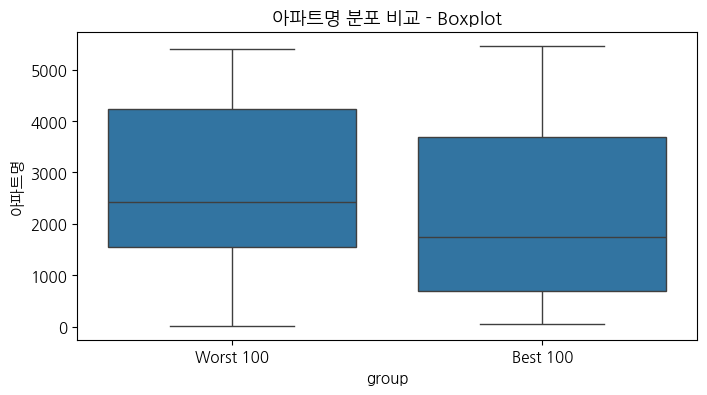

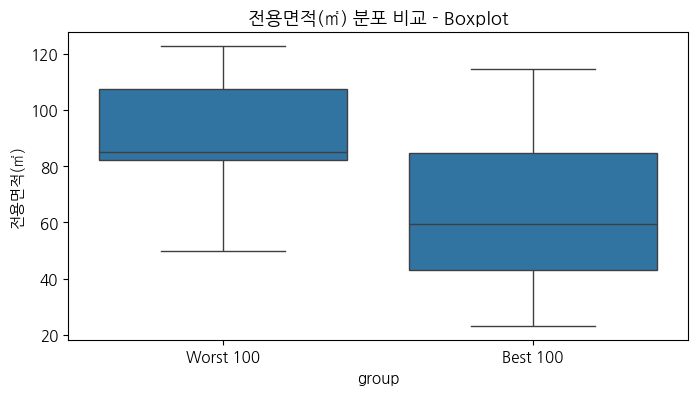

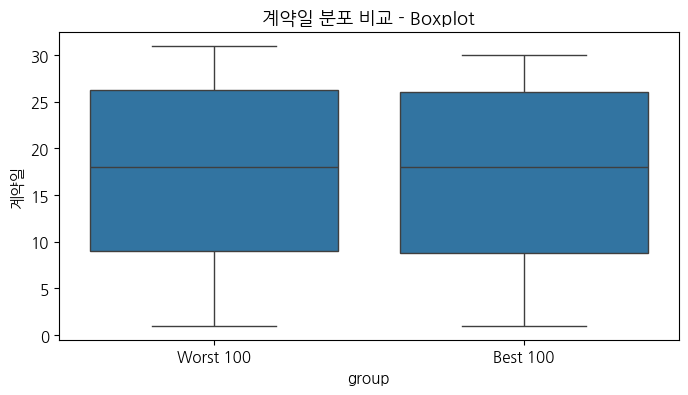

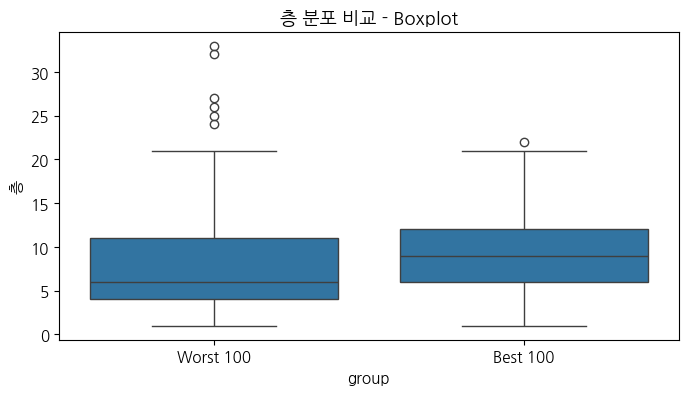

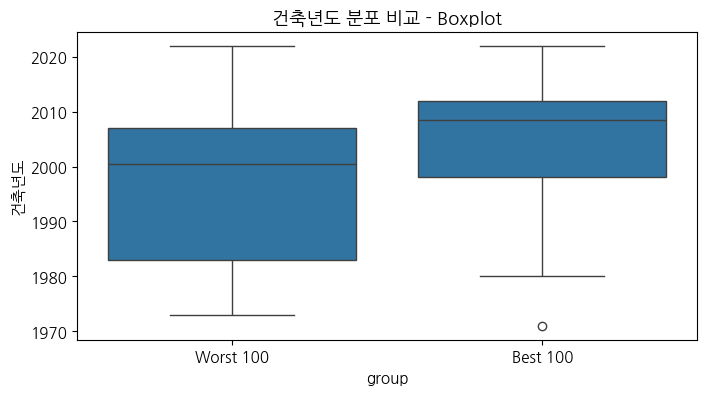

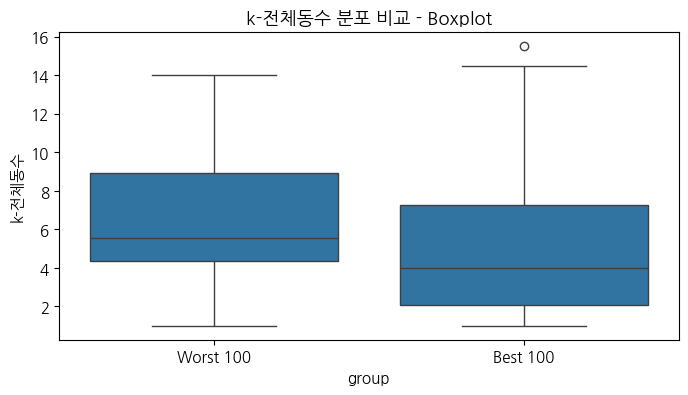

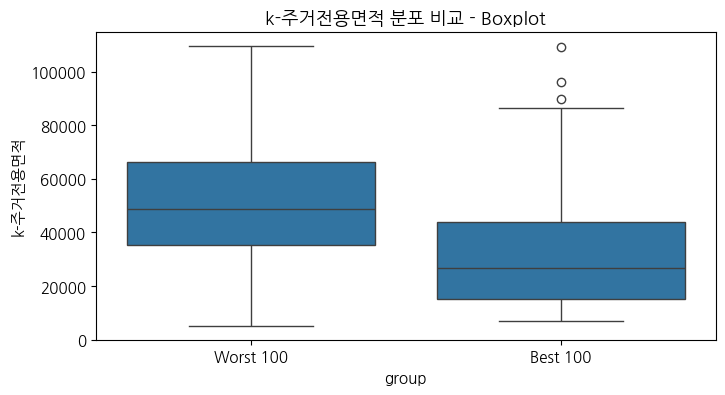

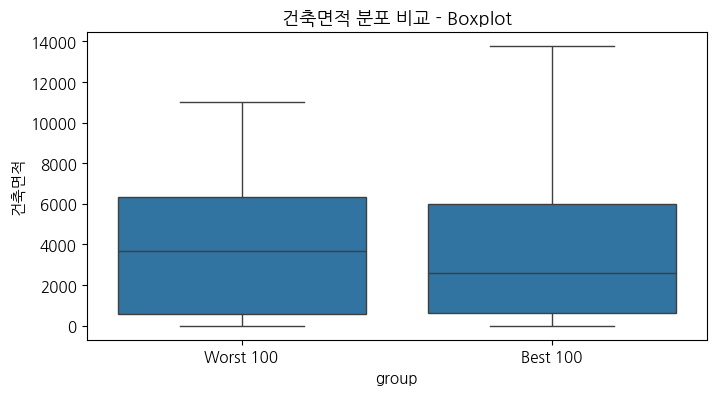

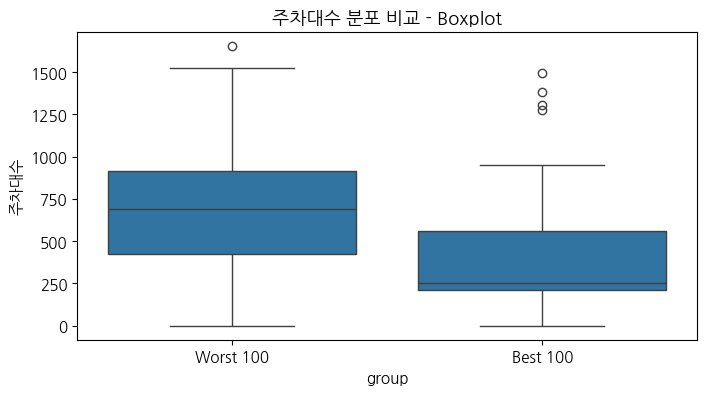

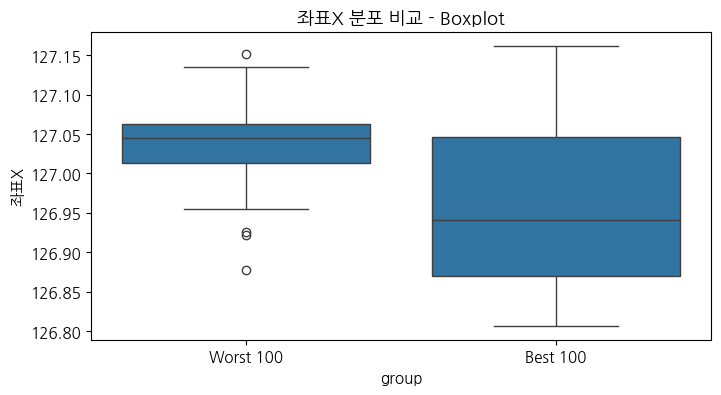

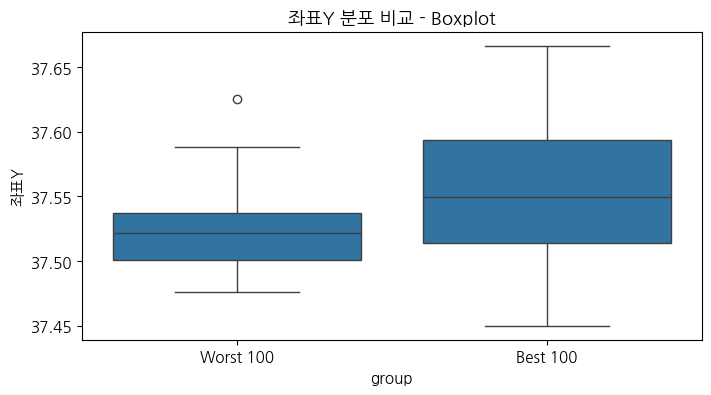

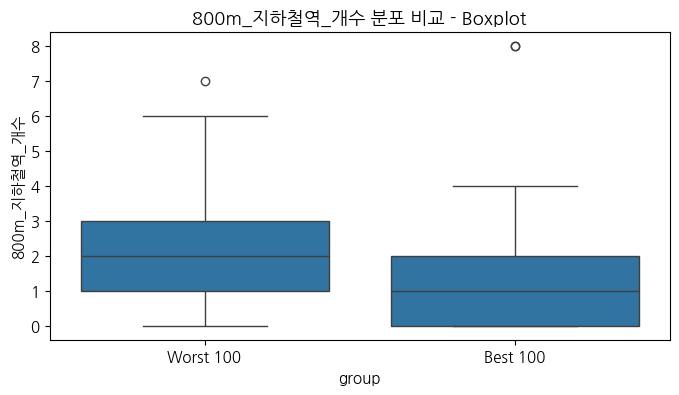

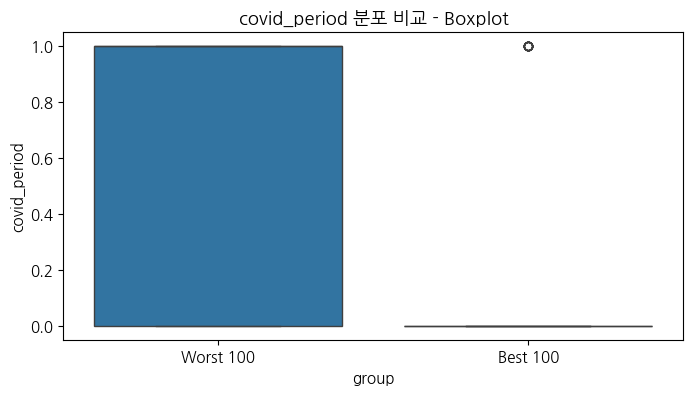

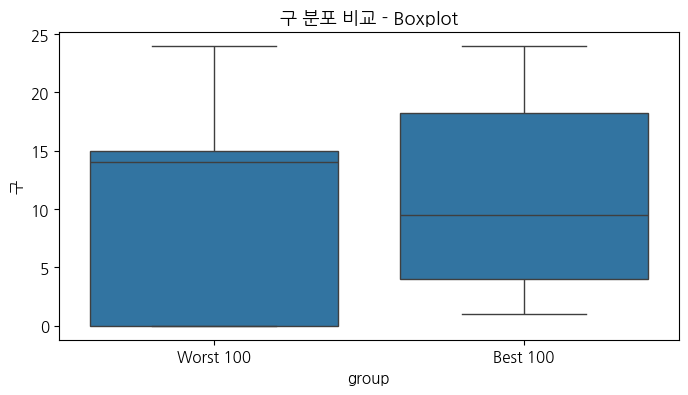

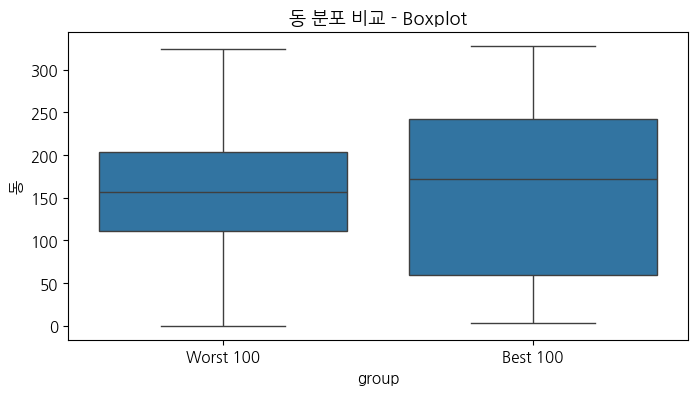

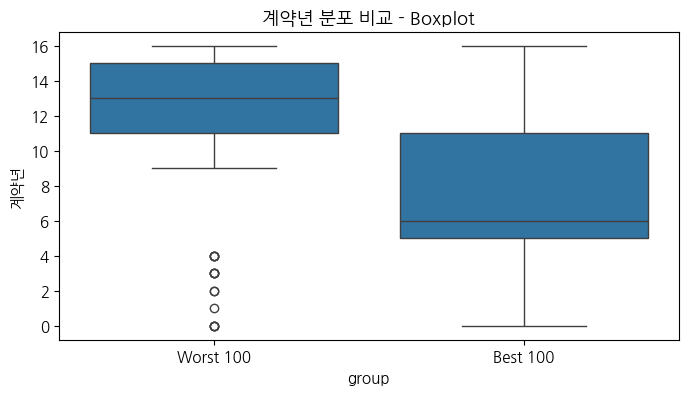

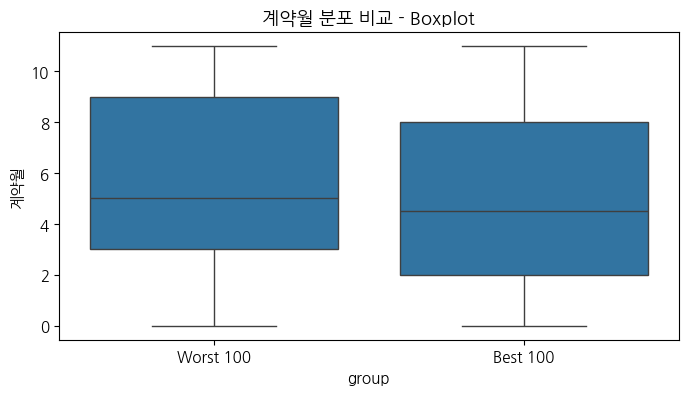

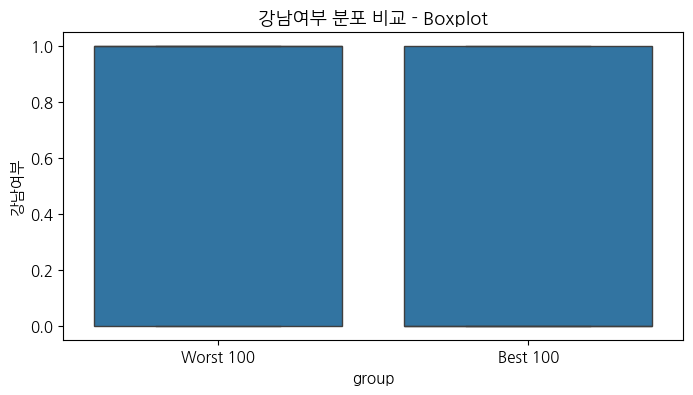

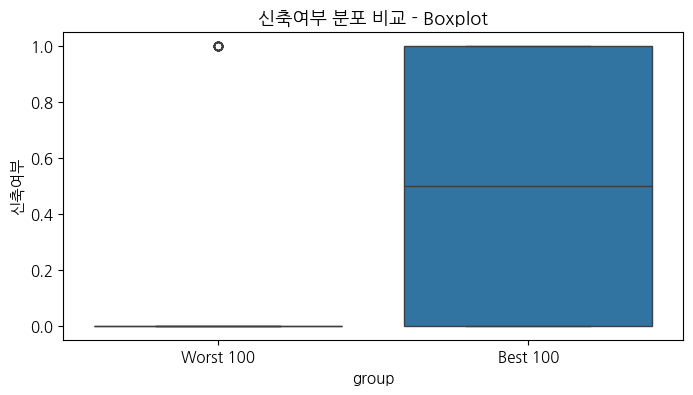

In [41]:
import pandas as pd

# 두 데이터프레임에 'group' 컬럼 추가해서 합치기
error_top100_cp = error_top100.copy()
best_top100_cp = best_top100.copy()
error_top100_cp['group'] = 'Worst 100'
best_top100_cp['group'] = 'Best 100'
df_box = pd.concat([error_top100_cp, best_top100_cp])

for col in num_cols:
    plt.figure(figsize=(8,4))
    try:
        sns.boxplot(x='group', y=col, data=df_box)
        plt.title(f"{col} 분포 비교 - Boxplot")
        plt.show()
    except Exception as e:
        print(f"{col} 시각화 중 오류 발생: {e}")

